In [1]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]
y_train_valid = to_categorical(y_train_valid - 769)
y_test = to_categorical(y_test - 769)

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [8]:
def crnn_model_smaller_than_300(kernel_initializer, time_period=300):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(32, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(CuDNNLSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=1e-8, weight_decay=0.01), metrics=[categorical_accuracy])
    
    return model

In [12]:
def crnn_model(kernel_initializer, time_period=1000):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(32, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))

    model.add(Conv2D(128, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.4))

    model.add(Permute((2, 3, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(CuDNNLSTM(128, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64, kernel_initializer=kernel_initializer, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32, kernel_initializer=kernel_initializer)))
    model.add(Dropout(0.4))
    model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=1e-8, weight_decay=0.01), metrics=[categorical_accuracy])
    
    return model

In [13]:
def train_data(sub_idx=None, time_period=1000):
    # different period of time
    X_train_valid_cur = X_train_valid[:, :, :time_period]
    y_train_valid_cur = y_train_valid
    X_test_cur = X_test[:, :, :time_period]
    y_test_cur = y_test
    
    # single subject dataset
    if sub_idx is not None:
        X_train_valid_cur = X_train_valid_cur[np.where(person_train_valid == sub_idx)[0]]
        y_train_valid_cur = y_train_valid[np.where(person_train_valid == sub_idx)[0]]
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    # preprocess data
    X_train_valid_cur = np.expand_dims(X_train_valid_cur, axis=3)
    X_test_cur = np.expand_dims(X_test_cur, axis=3)
    lecun = lecun_uniform(seed=42)
    
    if time_period < 300:
        model = crnn_model_smaller_than_300(lecun, time_period)
    else:
        model = crnn_model(lecun, time_period)
    model.fit(X_train_valid_cur, y_train_valid_cur, epochs=40, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=False)
    train_score = model.evaluate(X_train_valid_cur, y_train_valid_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    
    return train_score, test_score

In [14]:
train_score, test_score = train_data(time_period=1000)

14/14 [==============================] - 0s 9ms/step - loss: 1.6706 - categorical_accuracy: 0.5598
train categorical_accuracy: 93.617%
test categorical_accuracy: 55.982%
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 22, 991, 16)       176       
                                                                 
 elu_8 (ELU)                 (None, 22, 991, 16)       0         
                                                                 
 batch_normalization_8 (Batc  (None, 22, 991, 16)      88        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 991, 32)        10784     
                                                                 
 elu_9 (ELU)                 (None, 2, 991, 32)        0         
                

In [15]:
single_train_scores = []
single_test_scores = []
for i in range(9):
    train_score, test_score = train_data(sub_idx=i)
    single_train_scores.append(train_score[1])
    single_test_scores.append(test_score[1])

print("Single train accuracies: ")
print(single_train_scores)
print("Single test accuracies: ")
print(single_test_scores)

2/2 [==============================] - 0s 12ms/step - loss: 1.2553 - categorical_accuracy: 0.7000
train categorical_accuracy: 99.156%
test categorical_accuracy: 70.000%
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 22, 991, 16)       176       
                                                                 
 elu_12 (ELU)                (None, 22, 991, 16)       0         
                                                                 
 batch_normalization_12 (Bat  (None, 22, 991, 16)      88        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 991, 32)        10784     
                                                                 
 elu_13 (ELU)                (None, 2, 991, 32)        0         
                 

=================100===================
14/14 [==============================] - 0s 5ms/step - loss: 2.6125 - categorical_accuracy: 0.4560
train categorical_accuracy: 92.388%
test categorical_accuracy: 45.598%
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 22, 91, 16)        176       
                                                                 
 elu_48 (ELU)                (None, 22, 91, 16)        0         
                                                                 
 batch_normalization_48 (Bat  (None, 22, 91, 16)       88        
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 2, 91, 32)         10784     
                                                                 
 elu_49 (ELU)                (None, 2, 91

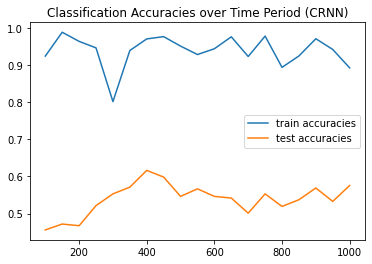

In [16]:
train_scores = []
test_scores = []

for time in range(100, 1001, 50):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(100 + 50 * max_idx))

# plot
plt.plot(range(100, 1001, 50), train_scores, label='train accuracies')
plt.plot(range(100, 1001, 50), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CRNN)")
plt.show()